In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping
import os
import shutil
import sys

In [2]:
# Load dataset
dataset_dir = '../input/dog-breed-identification/train'
labels = pd.read_csv('../input/dog-breed-identification/labels.csv')

In [3]:
# Number of classes
n_class = len(labels.breed.unique())
n_class

120

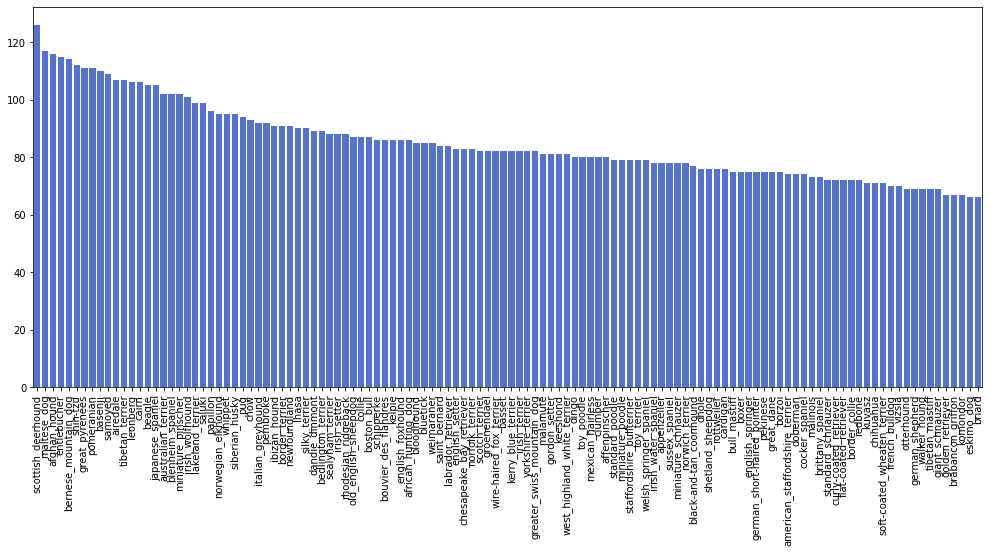

In [4]:
# Distribution of classes in the train dataset
import seaborn as sns
data = labels.breed.value_counts()

plt.figure(figsize=(17,7))
sns.barplot(x=data.index, y=data.values, color='royalblue')
plt.xticks(rotation=90)
plt.show()

## Preprocessing

First, we need to rearrange the images such that images of the same class are put in the same folder like the following. After the directory is set and done, we then can use Kera's flow_from_directory() method.

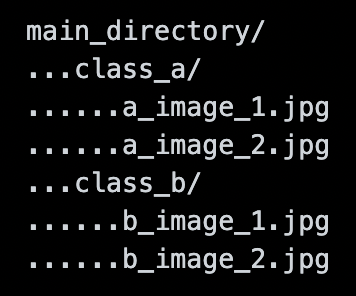

To begin with, let's create some helper functions

In [5]:
import os

def make_dir(x):
    if os.path.exists(x)==False:
        os.makedirs(x)
        
base_dir = './subset'
make_dir(base_dir)

Loop through the photos and arrange them in the right directory structure

In [6]:
# Set up directories for the training data
train_dir = os.path.join(base_dir, 'train')
make_dir(train_dir)

In [7]:
# Loop through images
breeds = labels.breed.unique()
for breed in breeds:
    # Make folder for each breed
    _ = os.path.join(train_dir, breed)
    make_dir(_)
    
    # Copy images to the corresponding folders
    images = labels[labels.breed == breed]['id']
    for image in images:
        source = os.path.join(dataset_dir, f'{image}.jpg')
        destination = os.path.join(train_dir, breed,f'{image}.jpg')                             
        shutil.copyfile(source, destination)

In [8]:
# Set batch size 64 as global variable
batch_size = 64

In [9]:
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255) # rescale pixel values to [0,1] to reduce memory usage

train_generator = datagen.flow_from_directory(
    directory=train_dir,
    target_size=(299, 299),
    batch_size=batch_size,
    class_mode='sparse',
    seed=123)

Found 10222 images belonging to 120 classes.


## Model building with InceptionResNetV2

In [10]:
from tensorflow.keras.applications import InceptionResNetV2

inception_bottleneck = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

2021-11-10 17:52:00.680612: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-10 17:52:00.800183: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-10 17:52:00.800952: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-10 17:52:00.802045: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

219070464/219055592 [==============================] - 1s 0us/step


In [11]:
# The shape of the features
feature_shape = inception_bottleneck.layers[-1].output_shape[1:]
print(f'The shape of each feature tensor is: {feature_shape}')

# Height, width and depth of the tensor
h = inception_bottleneck.layers[-1].output_shape[1]
w = inception_bottleneck.layers[-1].output_shape[2]
d = inception_bottleneck.layers[-1].output_shape[3]

The shape of each feature tensor is: (8, 8, 1536)


Extract features by processing the images with the pretrained model. Since the last dense layer(s) of the pretrained model is not used, the output will be a set of intermediate feature tensors (hence the name bottleneck,) which will be put into our own dense layers for final output.

In [12]:
# Number of training samples
train_samples = len(labels)

# Initialize tensors with zeros
X_train = np.zeros(shape=(train_samples, h, w, d), dtype=np.float32) # specify dtype as float32
y_train = np.zeros(shape=(train_samples))

# Update the tensors with the features outputed by the bottleneck model
len_ = 0
for input_batch, label_batch in train_generator:
    features_batch = inception_bottleneck.predict(input_batch)
    X_train[len_:len_+len(features_batch)] = features_batch
    y_train[len_:len_+len(features_batch)] = label_batch
    len_+=len(features_batch)
    if len_ == train_samples:
        break

2021-11-10 17:52:09.886917: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-10 17:52:13.634569: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


In [13]:
# Shape of the feature tensors -- 10222 samples, each with shape (8,8,1536)
size = sys.getsizeof(X_train)/(1024*1024)
print(f'Shape: {X_train.shape}\nSize: {size:.3g}MB')

Shape: (10222, 8, 8, 1536)
Size: 3.83e+03MB


In [14]:
# Flatten the feature tensors to 1D vectors 
X_train = np.reshape(X_train, (train_samples, h*w*d)) 
shape = X_train.shape
print(f'Shape: {shape}')

Shape: (10222, 98304)


In [15]:
# Build the final fully connected dense layers for classification
model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_dim=h*w*d))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(n_class, activation='softmax')) # using softmax, the result could be interpreted in probability distribution

# Compile model using the popular'adam' optimizer
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               50332160  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 120)               61560     
Total params: 50,656,376
Trainable params: 50,656,376
Non-trainable params: 0
_________________________________________________________________


In [16]:
# Train the model
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
epochs = 50

history = model.fit(X_train, y_train,
         epochs=epochs,
         batch_size=batch_size,
         validation_split=0.1,
         callbacks=[early_stop],
         verbose=1)

2021-11-10 17:54:48.845255: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 3617193984 exceeds 10% of free system memory.
2021-11-10 17:54:52.896598: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 3617193984 exceeds 10% of free system memory.


Epoch 1/50
144/144 [==============================] - 4s 23ms/step - loss: 2.3493 - accuracy: 0.6076 - val_loss: 0.8368 - val_accuracy: 0.8074
Epoch 2/50
144/144 [==============================] - 3s 22ms/step - loss: 0.9936 - accuracy: 0.7973 - val_loss: 0.7914 - val_accuracy: 0.8309
Epoch 3/50
144/144 [==============================] - 3s 20ms/step - loss: 0.8960 - accuracy: 0.8191 - val_loss: 0.8512 - val_accuracy: 0.8416
Epoch 4/50
144/144 [==============================] - 3s 20ms/step - loss: 0.6838 - accuracy: 0.8511 - val_loss: 0.7806 - val_accuracy: 0.8553
Epoch 5/50
144/144 [==============================] - 3s 21ms/step - loss: 0.6248 - accuracy: 0.8681 - val_loss: 0.6328 - val_accuracy: 0.8612
Epoch 6/50
144/144 [==============================] - 3s 24ms/step - loss: 0.4779 - accuracy: 0.8889 - val_loss: 0.6904 - val_accuracy: 0.8671
Epoch 7/50
144/144 [==============================] - 3s 20ms/step - loss: 0.3883 - accuracy: 0.9111 - val_loss: 0.6897 - val_accuracy: 0.8661

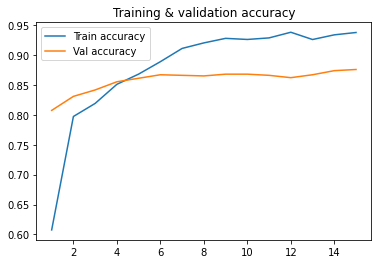

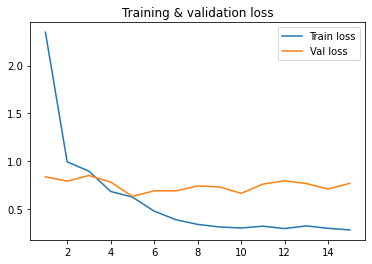

In [17]:
# Plot result
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Accuracy
plt.plot(epochs, acc, label='Train accuracy')
plt.plot(epochs, val_acc, label='Val accuracy')
plt.title('Training & validation accuracy')
plt.legend()

# Loss
plt.figure()
plt.plot(epochs, loss, label='Train loss')
plt.plot(epochs, val_loss, label='Val loss')
plt.title('Training & validation loss')
plt.legend()
plt.show()

## Test the model

In [18]:
import cv2
from PIL import Image

In [19]:
# Dictionary of breeds for decoding the one-hot-encoded prediction
breed_label = {j:i for i,j in train_generator.class_indices.items()}

# Crop the image to square
def crop_center(pil_img):
    img_w, img_h = pil_img.size
    hw = min(pil_img.size)
    return pil_img.crop(((img_w - hw) // 2,
                         (img_h - hw) // 2,
                         (img_w + hw) // 2,
                         (img_h + hw) // 2))

# Resize & reshape image array, extract features and return prediction
def predict(pil_img):
    img_array = np.array(crop_center(pil_img))
    image_array = cv2.resize(img_array, (299,299))/255
    image_array = np.reshape(image_array,(1,299,299,3))
    features = inception_bottleneck.predict(image_array)
    X = features.reshape((1,-1))
    prediction = model.predict(X)
    return breed_label[prediction.argmax()]

In [20]:
from PIL import Image
image = Image.open('../input/dog-breed-identification/test/0012a730dfa437f5f3613fb75efcd4ce.jpg')

In [21]:
# Predict
predict(image)

'english_setter'

I also made a simple Streamlit app to showcase the model!

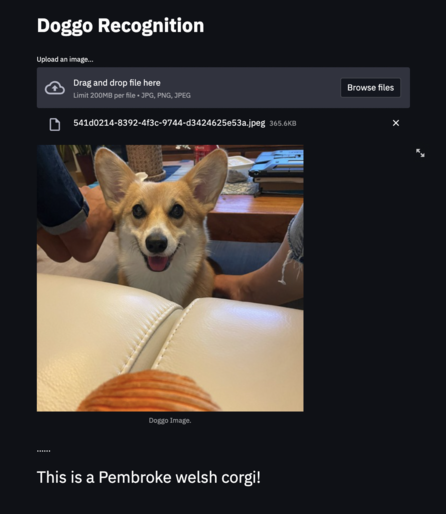